## Challenge C (Total: 2 Points):

##### Scenario 1:
The fact table ‘general_marketplaces.fct_listings’ is the central part of a
star schema and contains periodic snapshots of listings (classifieds). This table is partitioned on the
listing_date_key column and is clustered on the platform_id, product_type_id, status_id and user_id
columns. The dimensional table ‘general_marketplaces.dim_user’ contains granular
information about user location. The dimensional table
‘general_marketplaces.dim_product_type’ contains granular information about product
type tags.

##### Task 1 (2 Points): 
Please write a SQL script using BigQuery syntax that shows the top 3 countries by number of listings with the product type having the black color for product type tag.

In [1]:
import os
import pandas as pd
import pandas_gbq as pd_gbq
from google.cloud import bigquery
from google.cloud.exceptions import NotFound

In [4]:
### Create client using json file & project_id
client = bigquery.Client.from_service_account_json(json_credentials_path="credentials.json")

In [5]:
pysqldf = lambda q: sqldf(q, globals())

In [7]:
sql = """
 with product_listings as (
  select
      cl.*
    , dpt.product_type
    , du.location_city
    , dpt.product_type_tags_color
    , replace(dp.platform,'.ch','') as platform
    , date_diff(coalesce(last_update_date, DATE(2022,01,28)),  creation_date, day) as days_listed
  from `cln_listings.cln_listings`cl
  left join `dim_platform.dim_platform` dp on cl.platform_id = dp.platform_id and cl.creation_date between dp.valid_from and dp.valid_to
  left join `dim_product_type.dim_product_type` dpt on cl.product_type_id = dpt.product_type_id
  left join `dim_user.dim_user` du on cl.user_id = du.user_id
)
select 
      product_type_tags_color
    , location_city
    , count(distinct listing_id) as listings 
from product_listings 
group by 1,2 order by 3 desc
"""

df = client.query(sql).to_dataframe()

In [14]:
df[df.index<3]

,product_type_tags_color,location_city,listings
0,None,Geneva,34
1,None,Zurich,27
2,None,Lugano,18


<AxesSubplot:xlabel='location_city'>

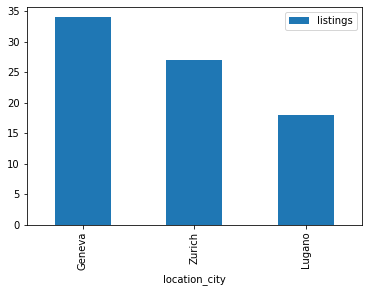

In [15]:
df[df.index<3].plot(kind='bar', x='location_city', y='listings')

## Dataset Issues

- The 'dim_users.csv' as I was sent it had missing values for location and location values. They were all null.
- Similarly within 'dim_product_type.csv' the following columns were all null:
    - product_type_tags
    - product_type_tags_weight_kg
    - product_type_tags_color

#### Manipulating RECORD and REPEATED columns:

If you have never used BigQuery, please check how to manipulate the RECORD and REPEATED columns:
For the RECORD column, a.k.a:
- STRUCT fields: you can query the ‘location.city’ column as follows:
    - SELECT location.city FROM ‘general_marketplaces.dim_user`



#### Note
- Before creating the dim_user table I formatted the RECORD/REPEATED columns from:
    - location.city to location_city

- Similarly, I formatted the column names in dim_product_types, from:
    - product_type.tags to product_type_tags
    - product_type.tags_weight_kg to product_type_tags_weight_kg
    - product_type.tags_color to product_type_tags_color

- I therefore had no need to use the method suggest above